# mLRSM comparisons
This notebook compares models in the mLRSM to different inputs such as the phase space factors and nuclear models to see their impact on the shapes

### Imports

In [1]:
import sys
sys.path.append("/Users/mistryk2/Packages/nudobe/src/")
sys.path.append("/Users/mistryk2/Packages/nudobe/")

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from nudobe import EFT
from EFT import LEFT

from nudobe import constants, functions
from constants import *

#import neutrino mixing matrix function
from functions import U_PMNS

#import multiprocessing

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import time


### Setup mLRSM

In [2]:
def get_masses(m_min           = 0, 
                ordering        = "NO", 
                Majorana_phases = [0,0], 
                v_R             = 10*TeV, 
                v_L             = 0.1*eV, 
                m_heavy         = np.array([10,12,13])*TeV,
                theta_L         = 0,
               ):
    U = U_PMNS(alpha=Majorana_phases)
    m = m_min
    
    if ordering == "NO" or ordering == "NH":
        m1 = m
        m2 = np.sqrt(m1**2+m21)
        m3 = np.sqrt(m2**2+m32)
    elif ordering == "IO" or ordering == "IH":
        m3 = m
        m2 = np.sqrt(m3**2-m32IO)
        m1 = np.sqrt(m2**2-m21)

    
    #diagonal light neutrino masses
    m_nu = np.diag([m1,m2,m3])*1e-9
    
    #diagonal heavy neutrino masses
    m_nu_R = np.diag(m_heavy)
    
    #non-diagonal light neutrino mass
    M_nu = U@m_nu@U.T
    
    #non-diagonal heavy neutrino mass
    M_nu_R = U@m_nu_R@U.T
    
    #inverse matrices
    M_nu_R_inv = np.linalg.inv(M_nu_R)
    
    M_nu_R_dagger_inv = np.linalg.inv(M_nu_R.T.conjugate())
    
    #non-diagonal yukawa matrices
    M_R = M_nu_R.T.conjugate()/(np.sqrt(2)*v_R)
    M_L = M_R.T.conjugate()
    
    M_nu_L = (np.sqrt(2) * v_L * np.exp(1j*theta_L) * M_L)
    
    #get the dirac yukawa matrix eq.57
    M_nu_D = U@m_nu_R@scipy.linalg.sqrtm(v_L/v_R*np.exp(1j*theta_L) * np.diag([1,1,1])
                                                          - np.linalg.inv(m_nu_R)@m_nu+0j)@U.T
    #return results
    return(m_nu, m_nu_R, M_nu_R, M_nu_R_inv, M_nu_R_dagger_inv, M_nu_D, M_nu_L)


# Gets the Wilson Coeficients at SMEFT
def GetWCs(m_min, v_R, v_L, m_heavy, theta_L, xi):
      m_nu, m_nu_R, M_nu_R, M_nu_R_inv, M_nu_R_dagger_inv, M_nu_D, M_nu_L = get_masses(
                                                                                    m_min           = 0, 
                                                                                    ordering        = "NO", 
                                                                                    Majorana_phases = [0,0], 
                                                                                    v_R             = v_R, 
                                                                                    v_L             = v_L, 
                                                                                    m_heavy         = m_heavy,
                                                                                    theta_L         = theta_L,
                                                                                    )


      # SMEFT
      C5         = 1/vev**2 * (M_nu_D.T@M_nu_R_inv@M_nu_D-M_nu_L)[0,0]
      C_LeudPhi7 = np.sqrt(2)/vev * (1/v_R**2 *(V_ud_R.conjugate()) * M_nu_D.T@M_nu_R_inv)[0,0]
      C_LPhiDe7  = 2j * xi*np.exp(1j * alpha) / (1 + xi**2) * C_LeudPhi7 / V_ud_R.conjugate()
      C_eeud9    = 0.88 * (-1 / (2 * v_R**4) * V_ud_R**2 * (M_nu_R_dagger_inv + 2 / m_DR**2 * M_nu_R))[0,0]
      C_eePhiud9 = -4 * (xi * np.exp(-1j * alpha)) / (1 + xi**2) * C_eeud9/V_ud_R
      C_eePhiD9  = 4 * xi**2 * np.exp(-2j * alpha) / ((1 + xi**2)**2) * C_eeud9/V_ud_R**2

      return {"LH(5)"      : C5, 
            "LeudH(7)"   : C_LeudPhi7, 
            "LHDe(7)"    : C_LPhiDe7, 
            "ddueue(9)"  : 4*np.conj(C_eeud9), 
            "deueH2D(9)" : -2 * np.conj(C_eePhiud9), 
            "eeH4D2(9)"  : -np.conj(C_eePhiD9)
            }

# Matches SMEFT wilson coeficients down to m_W scale using Table in Appendix A and Matching scheme in Appendix B
def GetWCsLEFT(m_min, v_R, v_L, m_heavy, theta_L, xi):
      SMEFT_WCs = GetWCs(0, v_R, v_L, m_heavy, theta_L, xi)

      m_bb   = -vev**2 * SMEFT_WCs["LH(5)"]
      C_VR6  = (vev**3/np.sqrt(2)) * SMEFT_WCs["LeudH(7)"].conjugate()
      C_VL6  = - (vev**3 * 1j) /np.sqrt(2) *V_ud * SMEFT_WCs["LHDe(7)"].conjugate()
      C_1R9p = - (vev**5 / 4) *  SMEFT_WCs["ddueue(9)"].conjugate()
      C_4R9  = -vev**5 * (V_ud/2) * SMEFT_WCs["deueH2D(9)"].conjugate()
      C_1R9  = -vev**5 * (V_ud/2) * SMEFT_WCs["eeH4D2(9)"].conjugate()

      return {
            "m_bb"       : m_bb,
            "VR(6)"      : C_VR6,
            "VL(6)"      : C_VL6,
            "1R(9)prime" : C_1R9p,
            "4R(9)"      : C_4R9,
            "1R(9)"      : C_1R9
      }

In [3]:
#Parameters

#masses
v_R  = 10*TeV
v_L  = 0.1*eV
m_DR = 4*TeV

#heavy neutrino masses
m_heavy = np.array([10,12,13])*TeV

#mixings
V_ud_R  = V_ud
V_ud_L  = V_ud
xi      = m_b/m_t
theta_L = 0
alpha   = 0

# Decide if you want to match the SMEFT operators down to LEFT operators
useLEFT = True

outfile = '../generation/generation_nudobe_test.txt'
imagefile = 'Model_test.png'

nbins = 100
eps = 1e-5 #avoid poles
nevts = 100000

Q = 2.457984 # Q-value in MeV units
me = 0.51099895 # electron mass in MeV units


# Define nu_L and xi for each model
Params = []

# mLRSM models
Model = {"v_L":0.1*eV, "xi": m_b/m_t}
Model = {"v_L":0.1*eV, "xi": 0}
Model = {"v_L":100*eV, "xi": m_b/m_t}
Model = {"v_L":100*eV, "xi": 0}

# NMEs
NMEs = []
NMEs.append("SM")
NMEs.append("IBM2")
NMEs.append("QRPA")

# PSFs
PSFs = []
PSFs.append("A")
PSFs.append("B")


Model_Wcs = []

# Add standard Mechanism
for m in range(len(Params)):
      Model_Wcs.append(GetWCs(0, v_R, Params[m]["v_L"], m_heavy, theta_L, Params[m]["xi"]))


if (useLEFT):
      print("Using matching LEFT operators of SMEFT")

Models = []


for m in range(len(Model_Wcs)):
      print(m)

      if (useLEFT):
            Models.append( EFT.LEFT(GetWCsLEFT(0, v_R, Params[m]["v_L"], m_heavy, theta_L, Params[m]["xi"]), name = f"mLRSM SM Model {m+1}", method = "SM"))
      else:
            Models.append(EFT.SMEFT(Model_Wcs[m], name = f"mLRSM SM Model {m+1}", method = "SM"))

# Add standard mechanism to compare to
Models.append(EFT.LEFT({"m_bb" : 28*meV}, name = "mbb SM Model", method = "SM"))

Using matching LEFT operators of SMEFT
0
1
2
3


In [4]:
# Set the model
model = Models[2]

for WC in model.WC:
    if model.WC[WC] != 0:
        print(WC, model.WC[WC])

model.t_half("136Xe")

m_bb (1.9002780345780945e-12-8.523482826832751e-13j)
VL(6) (-9.019513544211016e-11-2.8871235765782855e-28j)
VR(6) (1.864225321514261e-09+5.967338317544344e-27j)
1R(9) (-5.03710159720303e-11+1.0634491333085474e-12j)
1R(9)prime (4.1925285868643347e-08-8.851401557093658e-10j)
4R(9) (4.492876006261055e-09-9.485504714802962e-11j)
5R(9) (2.2448197885474673e-09-4.739335930588056e-11j)


6.331344035318774e+27

### First, sampling of electron kinetic energies

In [5]:
# Calculate momentum from kinetic energy
def p_fun(t): # valid for both e1 and e2
    p = np.sqrt(t*(t+2.*me))
    return p

In [6]:
# Define normalized energy array
ebar_vec = np.linspace(0+eps, 1-eps, nbins)

# Define array of electron kinetic energies and electron momenta
# ebar = (E_e - m_e)/Q = T_e/Q -> T_e = ebar*Q
t_vec = ebar_vec*Q
#print(t_vec)
p_vec = p_fun(t_vec)

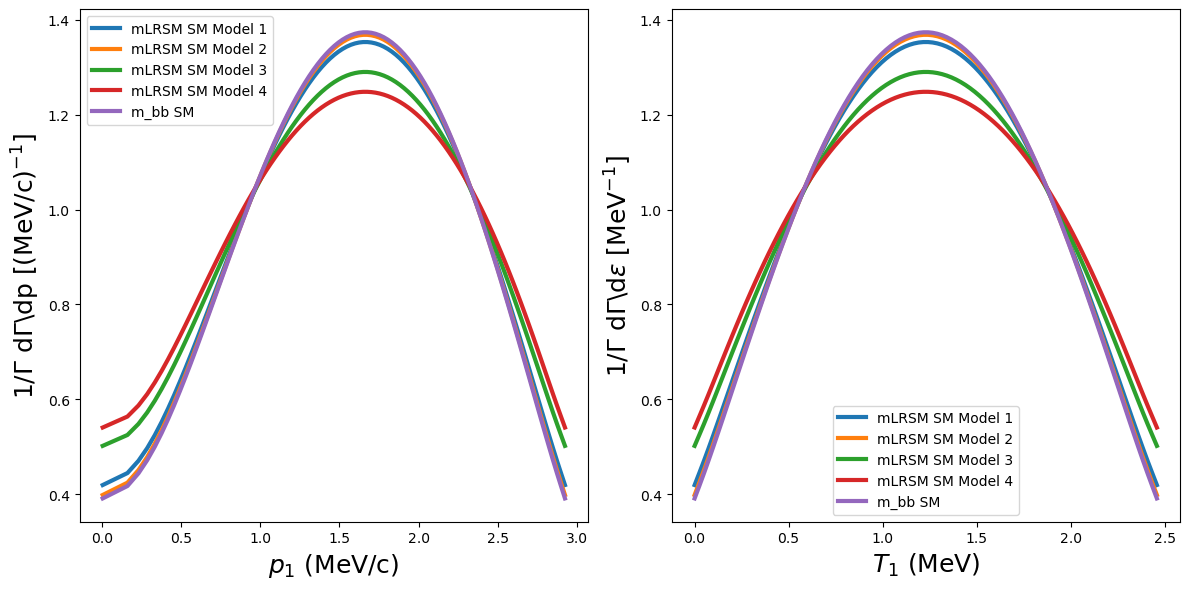

In [7]:
fig = plt.figure(figsize=(12, 6))

for m in range(len(Models)):

    rho_spec_vec = Models[m].spectrum(ebar_vec,isotope="136Xe")

    name = "m_bb SM"
    if (m<len(Model_Wcs)):
        name = f"mLRSM SM Model {m+1}"

    plt.subplot(121)
    plt.plot(p_vec, rho_spec_vec/sum(rho_spec_vec)*nbins, linewidth=3,label = name)
    plt.xlabel(r'$p_1$ (MeV/c)', fontsize=18)
    plt.ylabel("1/$\Gamma$ d$\Gamma$\dp [(MeV/c)$^{-1}$]", fontsize=18)
    plt.legend()

    plt.subplot(122)
    plt.plot(t_vec, rho_spec_vec/sum(rho_spec_vec)*nbins, linewidth=3,label = name)
    plt.xlabel(r'$T_1$ (MeV)', fontsize=18)
    plt.ylabel("1/$\Gamma$ d$\Gamma$\d$\epsilon$ [MeV$^{-1}$]", fontsize=18)
    plt.legend()

    plt.tight_layout()
    

In [8]:
# Find maximum, for random generation along y axis for accept-reject method
rho_spec_max = np.max(rho_spec_vec)
print("rho_spec_max = ", rho_spec_max)

p_max = p_fun(Q)
print(p_max)
t_max = Q
print(t_max)

rho_spec_max =  1.4356014749100583e-27
2.9246777310482606
2.457984


In [9]:
rho_spec_fun = interp1d(t_vec, rho_spec_vec, kind='linear', fill_value=(rho_spec_vec[0],rho_spec_vec[-1]), bounds_error=False)

In [10]:
t1_vec = np.zeros(nevts)
t2_vec = np.zeros(nevts)

ievt = 0

while ievt < nevts:

    t1 = np.random.uniform(low = 0., high = t_max)
    p1 = p_fun(t1)
    t2 = Q - t1
    p2 = p_fun(t2)
    
    if (t1 < 0 or t2 < 0 or t1 > t_max or t2 > t_max):
        print(t1,t2)
    
    f = np.random.uniform(low=0., high=rho_spec_max)  
 
    if (f < rho_spec_fun(t1)):
        t1_vec[ievt] = t1 # MeV units
        t2_vec[ievt] = t2 # MeC units
        ievt += 1
        
print("# accepted = ", ievt, " over ", nevts)

# accepted =  100000  over  100000


### Second, sampling of electron angular distributions

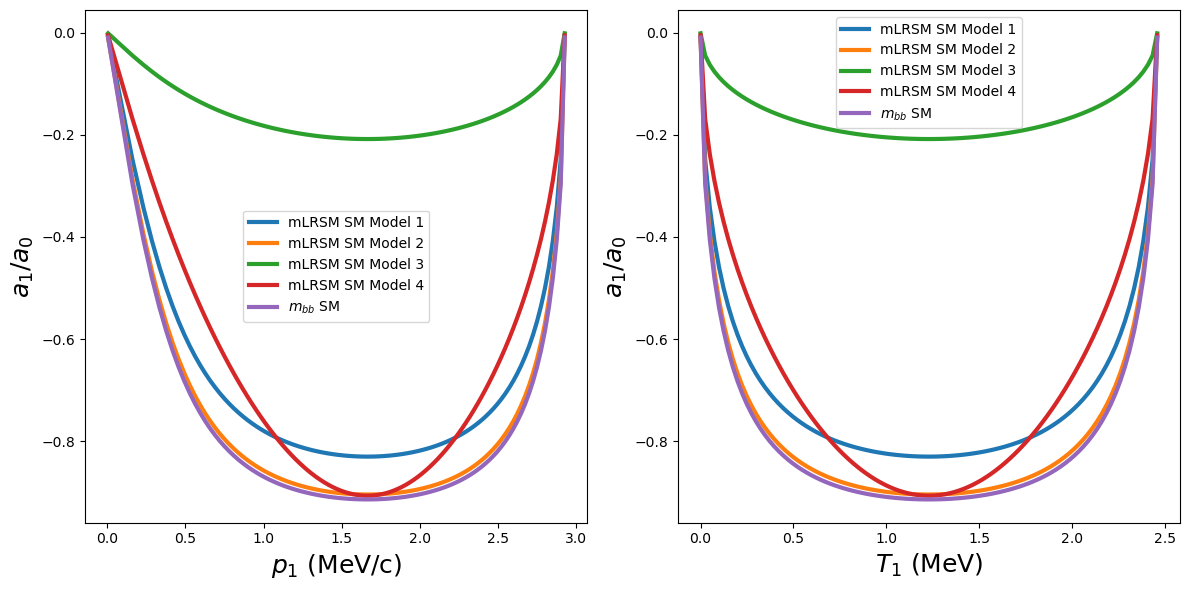

In [11]:
fig = plt.figure(figsize=(12, 6))

for m in range(len(Models)):

    rho_angle_vec = Models[m].angular_corr(ebar_vec,isotope="136Xe")

    name = "$m_{bb}$ SM"
    if (m<len(Model_Wcs)):
        name = f"mLRSM SM Model {m+1}"

    plt.subplot(121)
    plt.plot(p_vec, rho_angle_vec, linewidth=3,label = name)
    plt.xlabel(r'$p_1$ (MeV/c)', fontsize=18)
    plt.ylabel("$a_1/a_0$", fontsize=18)
    plt.legend()

    plt.subplot(122)
    plt.plot(t_vec, rho_angle_vec, linewidth=3,label = name)
    plt.xlabel(r'$T_1$ (MeV)', fontsize=18)
    plt.ylabel("$a_1/a_0$", fontsize=18)
    plt.legend()

    plt.tight_layout()

In [12]:
rho_angle_fun = interp1d(ebar_vec, rho_angle_vec, kind='linear', fill_value=(rho_angle_vec[0],rho_angle_vec[-1]), bounds_error=False)

In [13]:
def cos12_fun(theta1, phi1, theta2, phi2): #cos12 = (p1x*p2x + p1y*p2y + p1z*p2z) / (p1*p2)
    x = np.sin(theta1)*np.cos(phi1) * np.sin(theta2)*np.cos(phi2)
    y = np.sin(theta1)*np.sin(phi1) * np.sin(theta2)*np.sin(phi2)
    z = np.cos(theta1) * np.cos(theta2)
    return x+y+z

In [14]:
def eta_fun(ebar,theta1,phi1,theta2,phi2):
    eta = 1 + rho_angle_fun(ebar)*cos12_fun(theta1,phi1,theta2,phi2)
    return eta

In [15]:
theta1_vec = np.zeros(nevts)
theta2_vec = np.zeros(nevts)
phi1_vec = np.zeros(nevts)
phi2_vec = np.zeros(nevts)

ievt = 0

# Get vector of p1, p2, beta1 and beta2 values
p1_vec = p_fun(t1_vec)
p2_vec = p_fun(t2_vec)


while ievt < nevts:
    
    t1 = t1_vec[ievt]
    ebar = t1/Q
    # eta_max is for costheta=-1 or costheta=+1, depending on the sign of rho_angle_fun
    eta_max = max(1 - rho_angle_fun(ebar), 1 + rho_angle_fun(ebar))
    #print(ebar,eta_max)
    
    # Note: the cosine of polar angles need to be generated uniformly between -1 and +1. 
    costheta1 = np.random.uniform(low = -1., high = +1.)
    theta1 = np.arccos(costheta1)
    phi1 = np.random.uniform(low = 0., high = 2.*np.pi)
    
    costheta2 = np.random.uniform(low = -1., high = +1.)
    theta2 = np.arccos(costheta2)
    phi2 = np.random.uniform(low = 0., high = 2.*np.pi)
    
    f = np.random.uniform(low=0., high=eta_max) 
 
    if (f < eta_fun(ebar,theta1,phi1,theta2,phi2)):
        theta1_vec[ievt] = theta1 
        phi1_vec[ievt] = phi1
        theta2_vec[ievt] = theta2 
        phi2_vec[ievt] = phi2
        ievt += 1
        
print("# accepted = ", ievt, " over ", nevts)


# accepted =  100000  over  100000


### Define the momenta components $p_x, p_y, p_z$ of the electrons 

In [16]:
p1x_vec = np.zeros(nevts)
p1y_vec = np.zeros(nevts)
p1z_vec = np.zeros(nevts)

p2x_vec = np.zeros(nevts)
p2y_vec = np.zeros(nevts)
p2z_vec = np.zeros(nevts)


for ievt in range(nevts):
    p1x_vec[ievt] = p1_vec[ievt]*np.sin(theta1_vec[ievt])*np.cos(phi1_vec[ievt])
    p1y_vec[ievt] = p1_vec[ievt]*np.sin(theta1_vec[ievt])*np.sin(phi1_vec[ievt]) 
    p1z_vec[ievt] = p1_vec[ievt]*np.cos(theta1_vec[ievt])
    
    p2x_vec[ievt] = p2_vec[ievt]*np.sin(theta2_vec[ievt])*np.cos(phi2_vec[ievt])
    p2y_vec[ievt] = p2_vec[ievt]*np.sin(theta2_vec[ievt])*np.sin(phi2_vec[ievt]) 
    p2z_vec[ievt] = p2_vec[ievt]*np.cos(theta2_vec[ievt])

### Save in data file
preparing the output for Geant4

In [17]:
#with open(outfile, "w") as file:
#    file.write("First event and full number of events:\n")
#    file.write("{}  {}\n\n".format(1,nevts))
#    for i in range(nevts):
#        file.write(f"{i}  0.  2\n")
#        file.write("3  {:.5f}  {:.5f}  {:.5f}  {}\n".format(p1x_vec[i], p1y_vec[i], p1z_vec[i], 0.0000))
#        file.write("3  {:.5f}  {:.5f}  {:.5f}  {}\n".format(p2x_vec[i], p2y_vec[i], p2z_vec[i], 0.0000))

### Check the distributions

In [18]:
cos12_vec = cos12_fun(theta1_vec, phi1_vec, theta2_vec, phi2_vec)

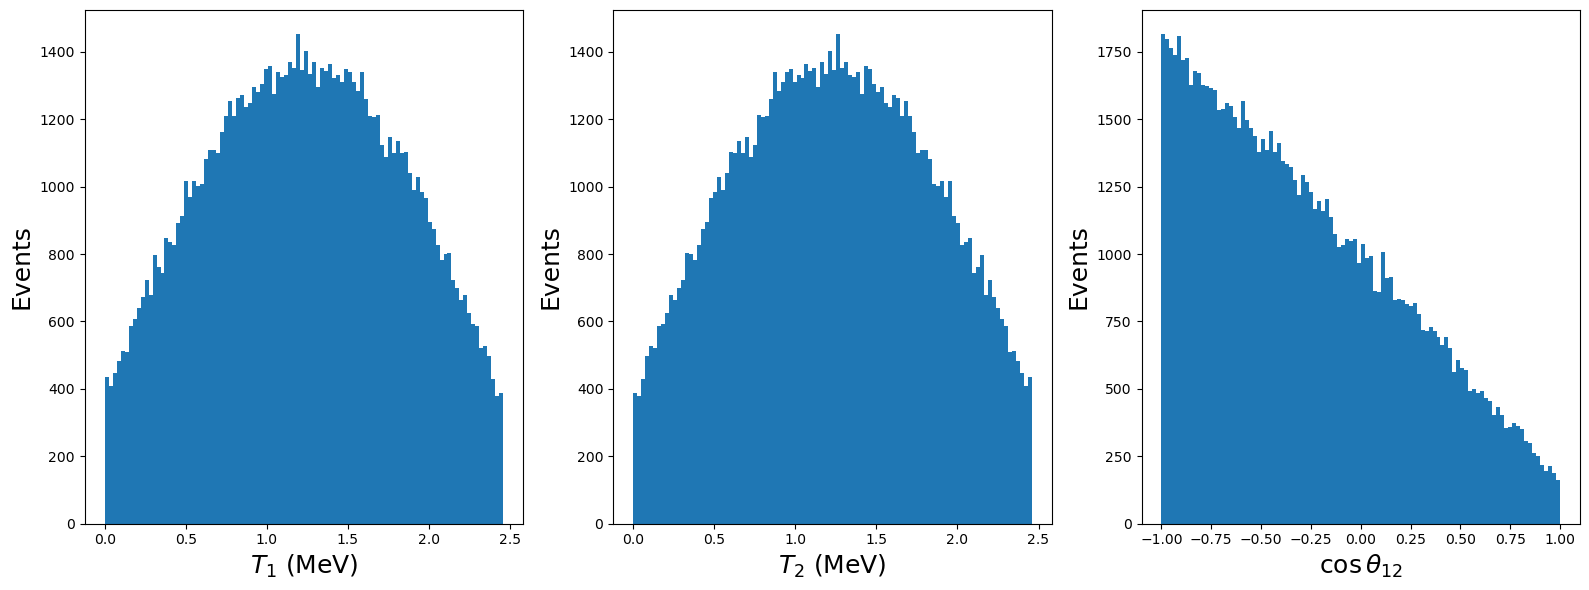

In [19]:
fig = plt.figure(figsize=(16, 6))

plt.subplot(131)
plt.hist(t1_vec, bins=100)
plt.xlabel(r'$T_1$ (MeV)', fontsize=18)
plt.ylabel('Events', fontsize=18)

plt.subplot(132)
plt.hist(t2_vec, bins=100)
plt.xlabel(r'$T_2$ (MeV)', fontsize=18)
plt.ylabel('Events', fontsize=18)

plt.subplot(133)
counts_costheta12, bins_costheta12, patches = plt.hist(cos12_vec, bins=100)
plt.xlabel(r'$\cos\theta_{12}$', fontsize=18)
plt.ylabel('Events', fontsize=18)

fig.tight_layout()
plt.savefig(imagefile)

### Compute dq2 for $T_1$, and Mean and for $\cos\theta_{12}$

In [20]:
def linear_fit(x,a,b):
    return a * (1 + b*x)

In [21]:
def dq2_fun(t1_vec):
    halfQ = Q/2.
    dq2 = 0
    for i in range(len(t1_vec)):
        dq2 += (t1_vec[i]-halfQ)**2
    dq2 = np.sqrt(dq2/len(t1_vec))
    dq2 = dq2/halfQ
    return dq2

In [22]:
dq2_t1 = dq2_fun(t1_vec)
print('dq2 T1:', round(dq2_t1,3))

mean_cos12 = np.mean(cos12_vec)
print('Mean cos12:', round(mean_cos12,3))

xdata = (bins_costheta12[:-1] + bins_costheta12[1:]) / 2
ydata = counts_costheta12
yerrdata = np.power(counts_costheta12, 1/2)
popt, pcov = curve_fit(linear_fit,xdata,ydata,sigma=yerrdata,p0=(1000.,-0.9),absolute_sigma=True,bounds=([0.,-1],[1.e6,1]))
#print(popt[0],popt[1])
#print(pcov)
#print('Slope cos12:', round(popt[1],3))

x_fine = np.linspace(-1,1,num=200)
y_fine = popt[0]*(1+popt[1]*x_fine)
#print(y_fine)

dq2 T1: 0.492
Mean cos12: -0.278


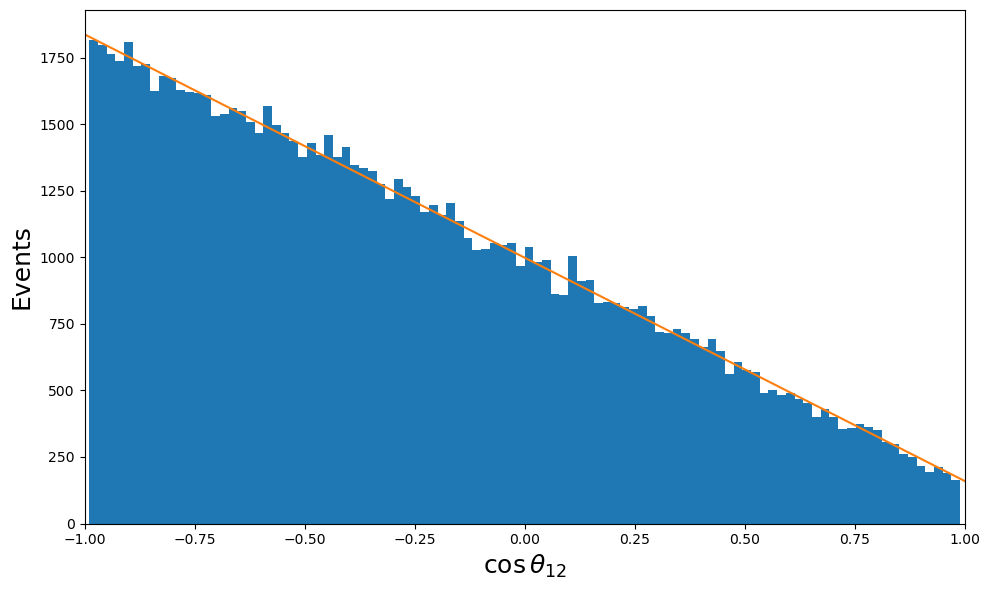

In [23]:
fig = plt.figure(figsize=(10, 6))
plt.hist(xdata,bins=nbins,weights=ydata)
plt.plot(x_fine,y_fine)
plt.xlim(-1.,1.)

plt.xlabel(r'$\cos\theta_{12}$', fontsize=18)
plt.ylabel('Events', fontsize=18)

fig.tight_layout()


### Table summarizing distribution features of various LEFT models

| Model | dq2 of $T_1$ dist. | Mean of $\cos\theta_{12}$ dist. |
| :-: | :-: | :-: |
| m_bb  | 0.492 | -0.283 |
| SL(6) | 0.492 | -0.283 |
| SR(6) | 0.492 | -0.280 | 
| T(6)  | 0.493 | -0.282 | 
| VL(6) | 0.495 | +0.256 | 
| VR(6) | 0.711 | +0.248 |
| VL(7) | 0.492 | -0.282 | 
| VR(7) | 0.491 | -0.282 | 
| 1L(9) | 0.492 | -0.280 | 
| 1R(9) | 0.492 | -0.279 | 
| 1L(9)prime | 0.493 | -0.282 | 
| 1R(9)prime | 0.492 | -0.279 | 
| 2L(9) | 0.491 | -0.281 | 
| 2R(9) | 0.493 | -0.279 | 
| 2L(9)prime | 0.493 | -0.280 | 
| 2R(9)prime | 0.492 | -0.280 | 
| 3L(9) | 0.493 | -0.279 | 
| 3R(9) | 0.492 | -0.284 | 
| 3L(9)prime | 0.491 | -0.282 | 
| 3R(9)prime | 0.493 | -0.283 | 
| 4L(9) | 0.492 | -0.283 | 
| 4R(9) | 0.491 | -0.280 | 
| 5L(9) | 0.493 | -0.283 | 
| 5R(9) | 0.491 | -0.282 | 
| 6(9) | 0.497 | +0.255 | 
| 6(9)prime | 0.495 | +0.251 | 
| 7(9) | 0.496 | +0.257 | 
| 7(9)prime | 0.496 | +0.252 | 
| 8(9) | 0.496 | +0.255 | 
| 8(9)prime | 0.498 | +0.255 | 
| 9(9) | 0.496 | +0.257 | 
| 9(9)prime | 0.497 | +0.252 | 
